In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import time
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier,RadiusNeighborsClassifier
import sklearn.metrics as sm

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix

import seaborn as sns


In [2]:
def get_batch(i):
    route = 'batch'+str(i)+'.csv'
    data = pd.read_csv(route,sep=' ',header=None,names=np.arange(0,257,1))
    data = pd.DataFrame(data)
    
    data1 = data.iloc[:,np.arange(0,257,2)]
    data1.columns=np.arange(0,129,1)
    return data1

In [3]:
def scatter_batch(batch,img_name):
    scatter_size=0.5
    plt.figure(figsize=(16,128))
    for i in range(1,129):
        ax=plt.subplot(32,4,i)
        ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        ax.get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        plt_num=0
        plt.scatter(range(plt_num,plt_num+len(batch[batch[0]==1])),batch[batch[0]==1][i],s=scatter_size)
        plt_num+=len(batch[batch[0]==1])
        plt.scatter(range(plt_num,plt_num+len(batch[batch[0]==2])),batch[batch[0]==2][i],s=scatter_size)
        plt_num+=len(batch[batch[0]==2])
        plt.scatter(range(plt_num,plt_num+len(batch[batch[0]==3])),batch[batch[0]==3][i],s=scatter_size)
        plt_num+=len(batch[batch[0]==3])
        plt.scatter(range(plt_num,plt_num+len(batch[batch[0]==4])),batch[batch[0]==4][i],s=scatter_size)
        plt_num+=len(batch[batch[0]==4])
        plt.scatter(range(plt_num,plt_num+len(batch[batch[0]==5])),batch[batch[0]==5][i],s=scatter_size)
        plt_num+=len(batch[batch[0]==5])
        plt.scatter(range(plt_num,plt_num+len(batch[batch[0]==6])),batch[batch[0]==6][i],s=scatter_size)
        plt_num+=len(batch[batch[0]==6])
    plt.show()

In [4]:
b1=get_batch(1); b1['batch']=1; b1['pred']=0;# b1['mean']=-1
b2=get_batch(2); b2['batch']=2; b2['pred']=0;# b2['mean']=-1
b3=get_batch(3); b3['batch']=3; b3['pred']=0;# b3['mean']=-1
b4=get_batch(4); b4['batch']=4; b4['pred']=0;# b4['mean']=-1
b5=get_batch(5); b5['batch']=5; b5['pred']=0;# b5['mean']=-1
b6=get_batch(6); b6['batch']=6; b6['pred']=0;# b6['mean']=-1
b7=get_batch(7); b7['batch']=7; b7['pred']=0;# b7['mean']=-1
b8=get_batch(8); b8['batch']=8; b8['pred']=0;# b8['mean']=-1
b9=get_batch(9); b9['batch']=9; b9['pred']=0;# b9['mean']=-1
b10=get_batch(10); b10['batch']=10; b10['pred']=0;# b10['mean']=-1

batch=pd.concat([b1,b2,b3,b4,b5,b6,b7,b8,b9,b10],axis=0,ignore_index=True)

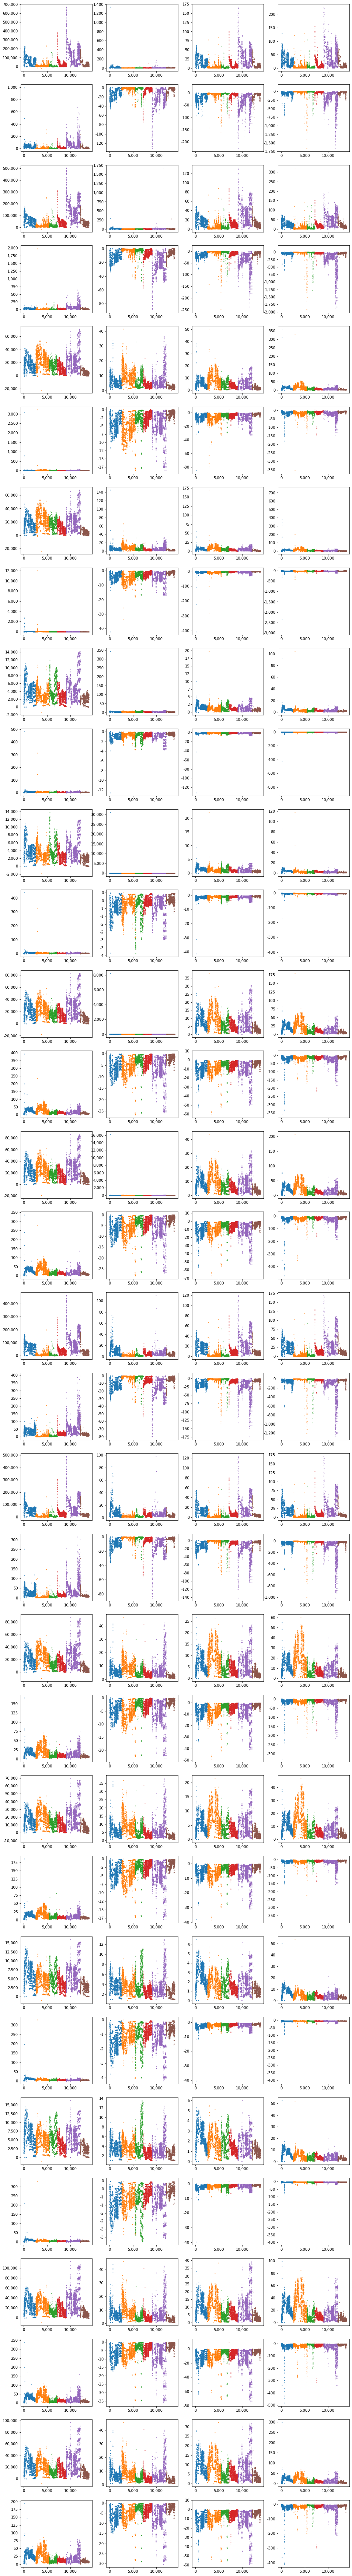

In [5]:
scatter_batch(batch,"Original_Sample")

In [6]:
batch.dropna(axis=0, how='any')
batch=batch.reset_index(drop=True)
batch_abs=abs(batch) 
value_limit=0.2
length=len(batch)
for i in range(1,129):
    mean=batch_abs.iloc[:,i].mean()
    for j in range(0,length):
        times=batch_abs.iloc[j,i]/mean
        if times>5 and times<20:
            batch_abs.iloc[j,i]=batch_abs.iloc[j,i]/10
        elif times>50 and times<200:
            batch_abs.iloc[j,i]=batch_abs.iloc[j,i]/100
        elif mean/batch_abs.iloc[j,i]<value_limit:
            batch_abs.iloc[j,i]=mean/value_limit
    imax=max(batch_abs.iloc[:,i])
    for j in range(0,length):
        batch.iloc[j,i]=batch_abs.iloc[j,i]/imax

In [7]:
batch_backup=batch

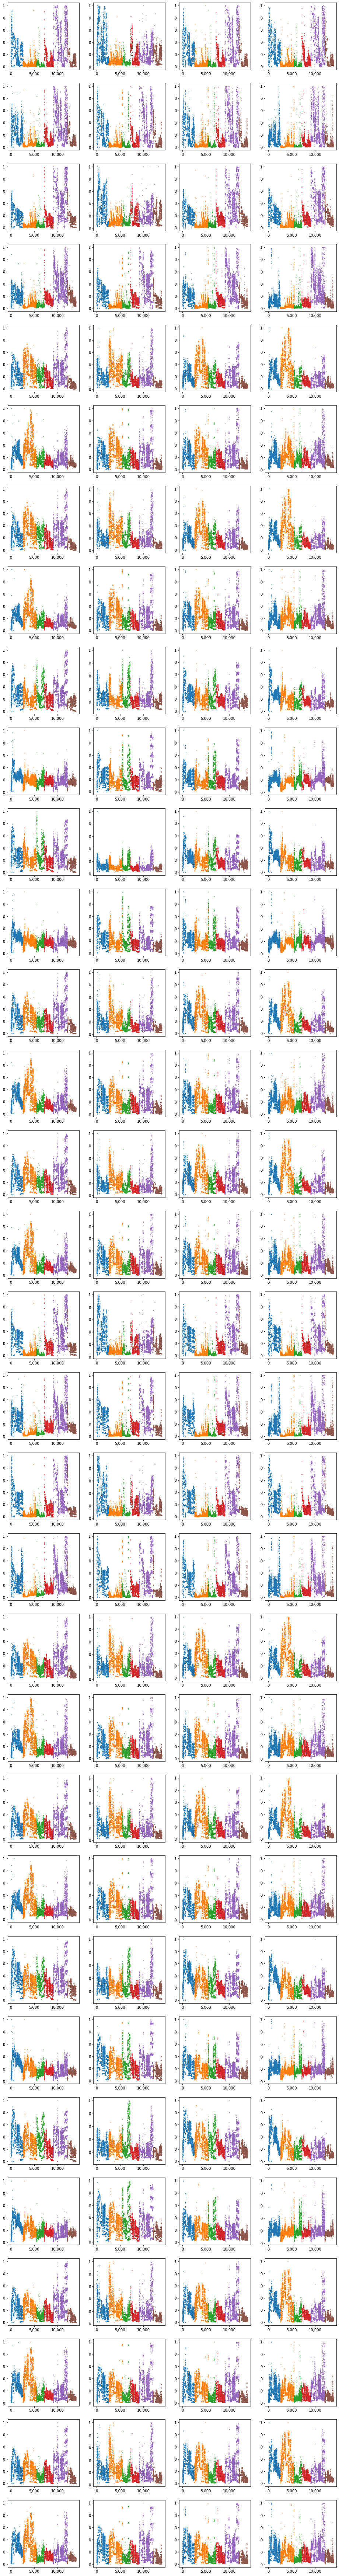

In [8]:
scatter_batch(batch,"Preprocessed_Samples")

In [9]:
def run(batch,ri,start_number,is_forget):
    plt.figure(figsize=(21,21))
    plt_num=1
    label_txt =  ['Ethanol','Ethylene','Ammonia','Acetaldehyde','Acetone','Toluene']
    label_txt_2 = ['Ethanol','Ethylene','Ammonia','Acetaldehyde','Acetone']
    start =time.perf_counter()
    remember_number=[0,ri,ri,ri,ri,ri,ri]
    step_number=10
    c=[pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame()]
    batch['pred']=0
    start_run=False
    start_idx=-1
    for idx,row in batch.iterrows():
        if not start_run:
            start_idx=idx+1
            row['pred']=row[0]
            if c[int(row[0])].empty:
                c[int(row[0])]=pd.DataFrame(row).T
            else:
                c[int(row[0])]=pd.concat([c[int(row[0])],pd.DataFrame(row).T],axis=0,ignore_index=True)
            if is_forget:
                c[int(row[0])]=c[int(row[0])].tail(remember_number[int(row[0])])
            start_run=True
            for ci in range(1,7):
                if len(c[ci])<start_number[ci]:
                    start_run=False
                    break
        else:
            print("Initializing the sample set ... Finish")
            break
    start2 =time.perf_counter()
    start_step=0
    for idx,row in batch.iloc[start_idx:,:].iterrows():
        start_step+=1
        train=pd.concat([c[1],c[2],c[3],c[4],c[5],c[6]],axis=0,ignore_index=True)    
        train_X,train_Y=train.iloc[:,1:-2],train.iloc[:,-1]
    
        svm = SVC(decision_function_shape="ovo").fit(train_X,train_Y)
        
        #svm=KNeighborsClassifier(n_neighbors=6).fit(cancer_train,train_Y)
        #svm= RadiusNeighborsClassifier(n_neighbors=6, radius=500.0).fit(cancer_train,train_Y)
        #svm=RandomForestClassifier().fit(cancer_train,train_Y)
        
        test_X=pd.DataFrame(row).T
        test_X=test_X.iloc[:,1:-2]
        target_pred = svm.predict(test_X)
        target_pred=int(target_pred)
        row['pred']=target_pred
        batch.loc[idx,'pred']=target_pred
        
        c[target_pred]=pd.concat([c[target_pred],pd.DataFrame(row).T],axis=0,ignore_index=True)
        if is_forget:
            c[target_pred]=c[target_pred].tail(remember_number[target_pred])
            
    end =time.perf_counter()
    list_acc=[0,0,0,0,0,0,0,0,0,0,0]
    print("is_forget:",is_forget,"queue_capacity:",remember_number,"coefficient_for_starting_training:",start_number)    
    ta=[pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame()]
    tp=[pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame()]
    for bi in range(1,11):
        ta[bi]=batch.loc[(batch['batch']==bi)&(batch['pred']!=0),0]
        tp[bi]=batch.loc[(batch['batch']==bi)&(batch['pred']!=0),'pred']
        if not ta[bi].empty: 
            list_acc[bi]=accuracy_score(ta[bi],tp[bi])
            cm=confusion_matrix(ta[bi],tp[bi])
            print(cm)
            ax=plt.subplot(3,3,plt_num)
            plt_num+=1
            cm_normalized = cm #cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
            cm_df=pd.DataFrame(cm)
            sns.heatmap(cm_normalized, ax=ax, fmt="d", cmap="RdBu_r",annot=True, linewidths=0.3, square=True,
                xticklabels=1, yticklabels=1)
            if len(cm)==6:
                ax.set_xticklabels(label_txt, rotation=50, horizontalalignment='left', family='Times New Roman', fontsize=12)
                ax.set_yticklabels(label_txt, rotation=0, family='Times New Roman', fontsize=12)
            else:
                ax.set_xticklabels(label_txt_2, rotation=50, horizontalalignment='left', family='Times New Roman', fontsize=12)
                ax.set_yticklabels(label_txt_2, rotation=0, family='Times New Roman', fontsize=12)
            ax.xaxis.set_ticks_position("top")
    plt.show()        
    print(list_acc)
    print('Initialization time: %s'%(start2-start))
    print('Online analysis time: %s'%(end-start2))
    print('Number of online processing steps: %s'%start_step)

Initializing the sample set ... Finish
is_forget: True queue_capacity: [0, 100, 100, 100, 100, 100, 100] coefficient_for_starting_training: [0, 90, 98, 83, 30, 70, 74]
[[148  16   0   0   0   0]
 [  0 328   5   0   1   0]
 [  0   0 100   0   0   0]
 [105   0   0   0   0   4]
 [  1   0   0 162 266 103]
 [  0   0   0   0   0   5]]
[[  1 359   5   0   0   0]
 [  0 490   0   0   0   0]
 [  4   0 212   0   0   0]
 [240   0   0   0   0   0]
 [  1   0  11 124  47  92]
 [  0   0   0   0   0   0]]
[[ 8 30  0  0 26]
 [ 1 42  0  0  0]
 [ 0  0 12  0  0]
 [20 10  0  0  0]
 [ 0  0  0 12  0]]
[[12  0  0  0 16]
 [ 0 40  0  0  0]
 [ 5  0 14  1  0]
 [46  0  0  0  0]
 [ 2  3  0 58  0]]
[[435   0   0  18   0  61]
 [ 50 472   0   0   0  52]
 [  0   0 101   3   0   6]
 [ 26   0   3   0   0   0]
 [ 16   0   0 232   0 358]
 [ 54   0 340   1   0  72]]
[[189 137   0 248   0  75]
 [177 170   0 240   2  73]
 [  0 205   2   0   0 153]
 [  0 179 298   0   0 267]
 [208   3 254  98   0  67]
 [  0 108 132   0   0 328]

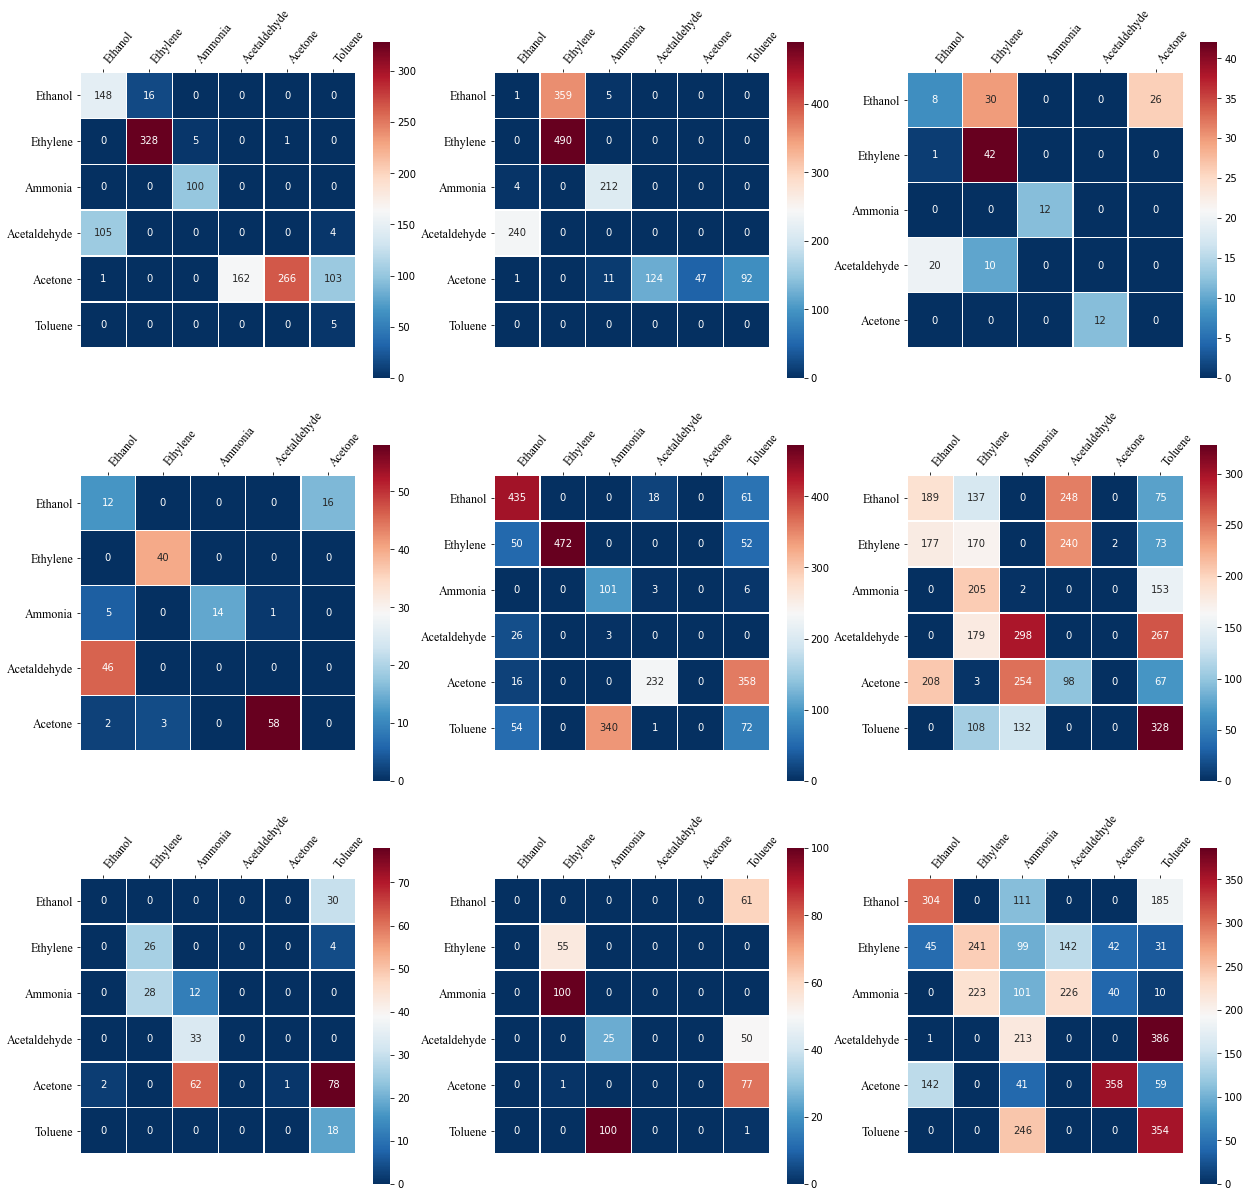

[0, 0, 0.6808681672025724, 0.4728877679697352, 0.38509316770186336, 0.3350253807106599, 0.46956521739130436, 0.19070024910047054, 0.19387755102040816, 0.11914893617021277, 0.37722222222222224]
Initialization time: 0.8082637999999633
Online analysis time: 264.3358108000001
Number of online processing steps: 13465


In [10]:
batch=batch_backup
is_forget=True
start_number=[0,90,98,83,30,70,74]  #batch1
ri=100
run(batch,ri,start_number,is_forget)

Initializing the sample set ... Finish
is_forget: True queue_capacity: [0, 200, 200, 200, 200, 200, 200] coefficient_for_starting_training: [0, 90, 98, 83, 30, 70, 74]
[[148  16   0   0   0   0]
 [  0 333   0   0   1   0]
 [  0   0 100   0   0   0]
 [109   0   0   0   0   0]
 [  1   0   0 160 348  23]
 [  0   0   0   0   0   5]]
[[358   1   6   0   0   0]
 [  0 490   0   0   0   0]
 [  4   0 212   0   0   0]
 [240   0   0   0   0   0]
 [  0   0   6  76 149  44]
 [  0   0   0   0   0   0]]
[[ 8 30  0  0 26]
 [ 1 42  0  0  0]
 [ 0  0 12  0  0]
 [20 10  0  0  0]
 [ 0  0  0  0 12]]
[[12  0  0  0 16]
 [ 0 40  0  0  0]
 [ 2  0 17  0  1]
 [46  0  0  0  0]
 [ 4  3  0  0 56]]
[[436   0   0   0  20  58]
 [ 50 472  52   0   0   0]
 [  0   0 101   3   4   2]
 [ 26   0   3   0   0   0]
 [  0   0  38  73 185 310]
 [  0   0  56   0   1 410]]
[[231   0 122   0 296   0]
 [ 83  91  84   0 404   0]
 [  0 207 151   2   0   0]
 [329   0 300 114   0   1]
 [ 19   0  72 250 227  62]
 [187   0 381   0   0   0]

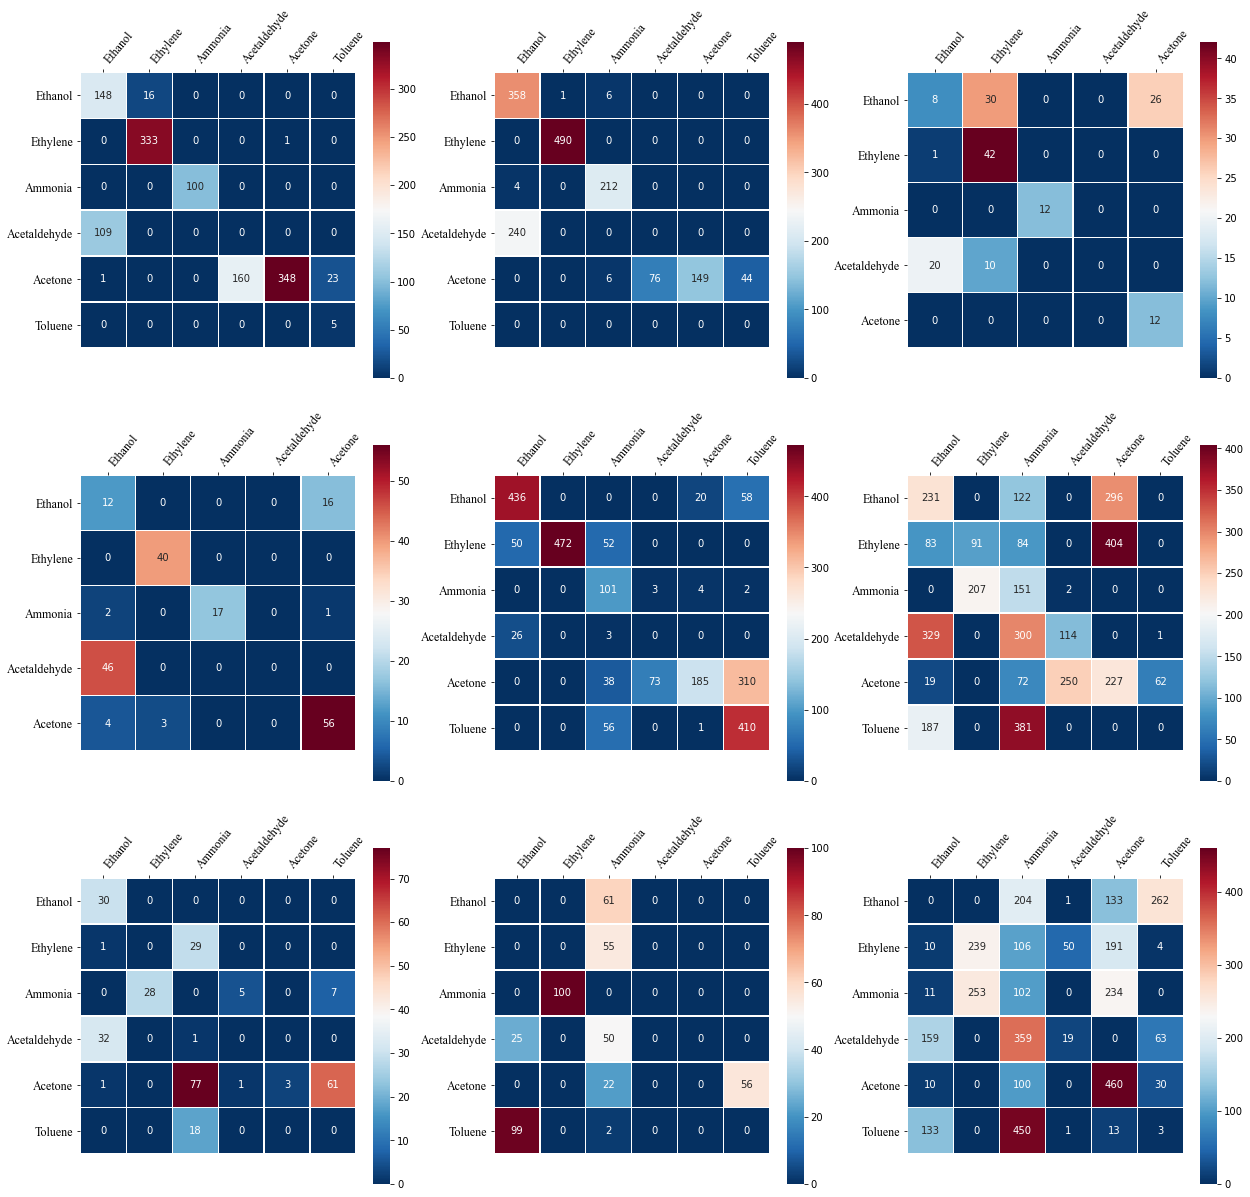

[0, 0, 0.7508038585209004, 0.7622950819672131, 0.45962732919254656, 0.6345177664974619, 0.697391304347826, 0.22529753667312483, 0.11224489795918367, 0.0, 0.2286111111111111]
Initialization time: 0.6895357999999305
Online analysis time: 480.1329734000001
Number of online processing steps: 13465


In [11]:
batch=batch_backup
is_forget=True
start_number=[0,90,98,83,30,70,74]  #batch1
ri=200
run(batch,ri,start_number,is_forget)

Initializing the sample set ... Finish
is_forget: True queue_capacity: [0, 300, 300, 300, 300, 300, 300] coefficient_for_starting_training: [0, 90, 98, 83, 30, 70, 74]
[[148  16   0   0   0   0]
 [  0 333   0   0   1   0]
 [  0   0 100   0   0   0]
 [109   0   0   0   0   0]
 [ 21   0   0   1 508   2]
 [  0   0   0   0   0   5]]
[[359   1   5   0   0   0]
 [  0 490   0   0   0   0]
 [  4   0 212   0   0   0]
 [240   0   0   0   0   0]
 [  0   0  11   1 261   2]
 [  0   0   0   0   0   0]]
[[ 8 30  0  0 26]
 [ 1 42  0  0  0]
 [ 0  0 12  0  0]
 [20 10  0  0  0]
 [ 0  0  0  0 12]]
[[12  0  0  0 16]
 [ 0 40  0  0  0]
 [ 1  0 18  0  1]
 [46  0  0  0  0]
 [ 2  3  0  0 58]]
[[434   0   0   0  80   0]
 [ 50 472  52   0   0   0]
 [  0   0 101   0   9   0]
 [ 26   0   3   0   0   0]
 [  0   0 303   1 302   0]
 [  0   0  53   1 413   0]]
[[419   0  74 156   0   0]
 [ 44 239  61 318   0   0]
 [  0 210 148   0   2   0]
 [455   0 288   0   1   0]
 [  8   1  76 278 267   0]
 [249   0 319   0   0   0]

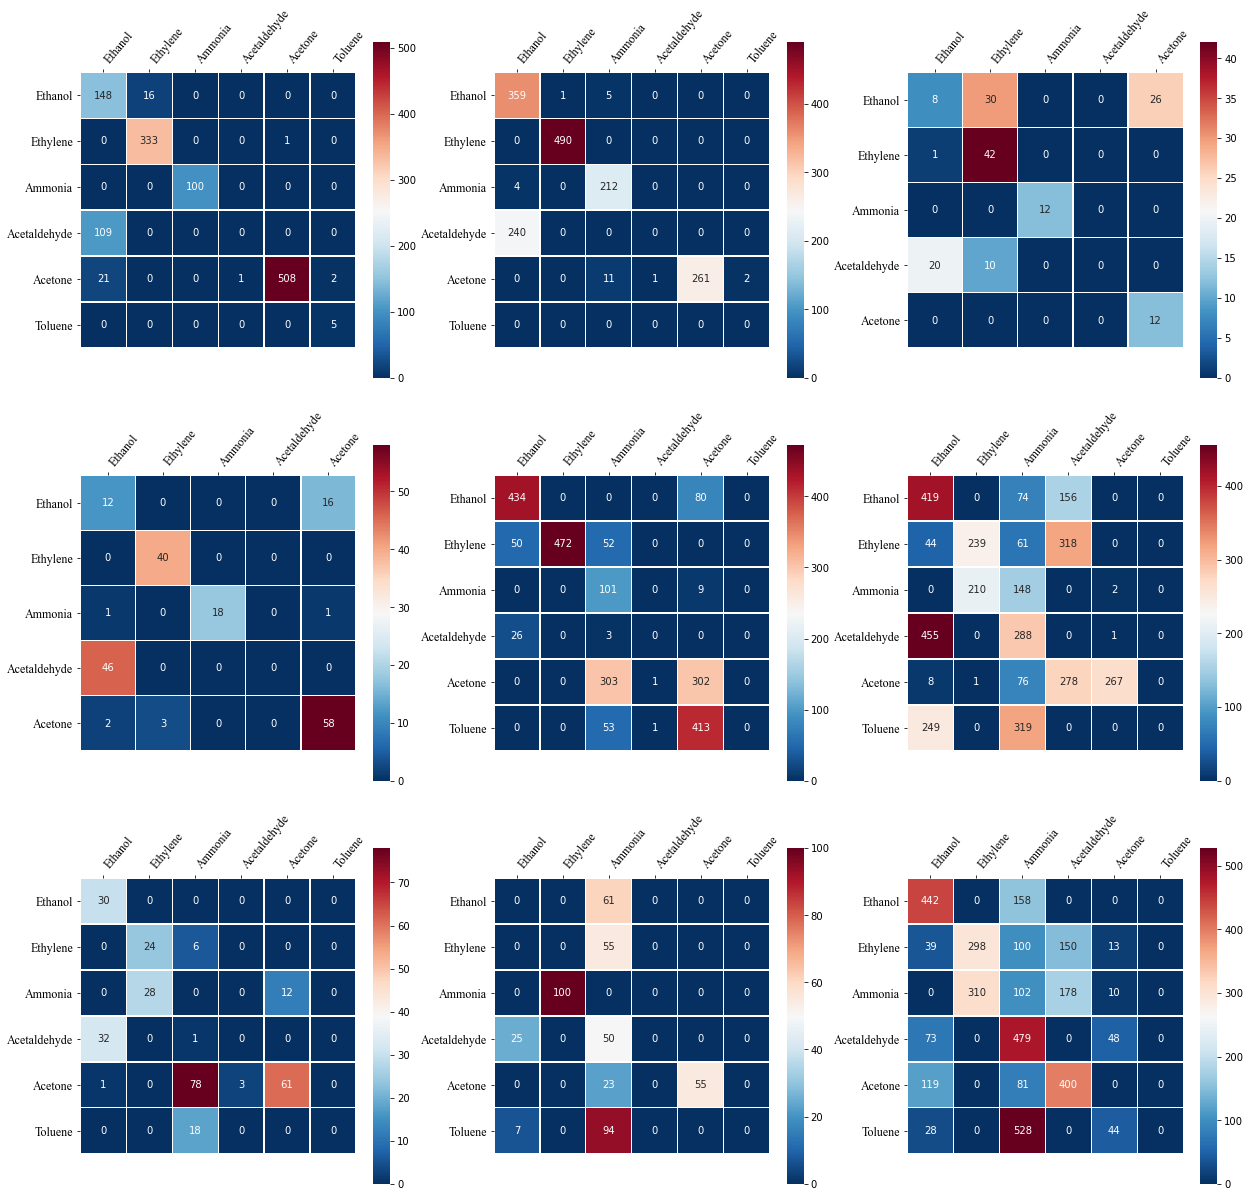

[0, 0, 0.8794212218649518, 0.8335435056746532, 0.45962732919254656, 0.649746192893401, 0.5691304347826087, 0.29698311652366455, 0.391156462585034, 0.11702127659574468, 0.2338888888888889]
Initialization time: 0.7582563000000846
Online analysis time: 604.6479359
Number of online processing steps: 13465


In [12]:
batch=batch_backup
is_forget=True
start_number=[0,90,98,83,30,70,74]  #batch1
ri=300
run(batch,ri,start_number,is_forget)

Initializing the sample set ... Finish
is_forget: True queue_capacity: [0, 400, 400, 400, 400, 400, 400] coefficient_for_starting_training: [0, 90, 98, 83, 30, 70, 74]
[[148  16   0   0   0   0]
 [  0 333   0   0   1   0]
 [  0   0 100   0   0   0]
 [109   0   0   0   0   0]
 [ 21   0   0   1 508   2]
 [  0   0   0   0   0   5]]
[[359   1   5   0   0   0]
 [  0 490   0   0   0   0]
 [  4   0 212   0   0   0]
 [240   0   0   0   0   0]
 [  0   0  11   1 261   2]
 [  0   0   0   0   0   0]]
[[64  0  0  0  0]
 [ 1 42  0  0  0]
 [ 0  0 12  0  0]
 [30  0  0  0  0]
 [ 0  0  0  0 12]]
[[28  0  0  0  0]
 [ 0 40  0  0  0]
 [ 1  0 18  0  1]
 [46  0  0  0  0]
 [ 5  0  0  0 58]]
[[437   0   0   0  77   0]
 [ 50 472  52   0   0   0]
 [  0   0 101   0   9   0]
 [ 26   0   3   0   0   0]
 [  0   0 303   0 303   0]
 [  0   0  56   0 411   0]]
[[649   0   0   0   0   0]
 [  3 597  61   1   0   0]
 [  0 210 148   0   2   0]
 [  0   0 290   0 454   0]
 [266   1  77   0 286   0]
 [  0   0 331   0 237   0]

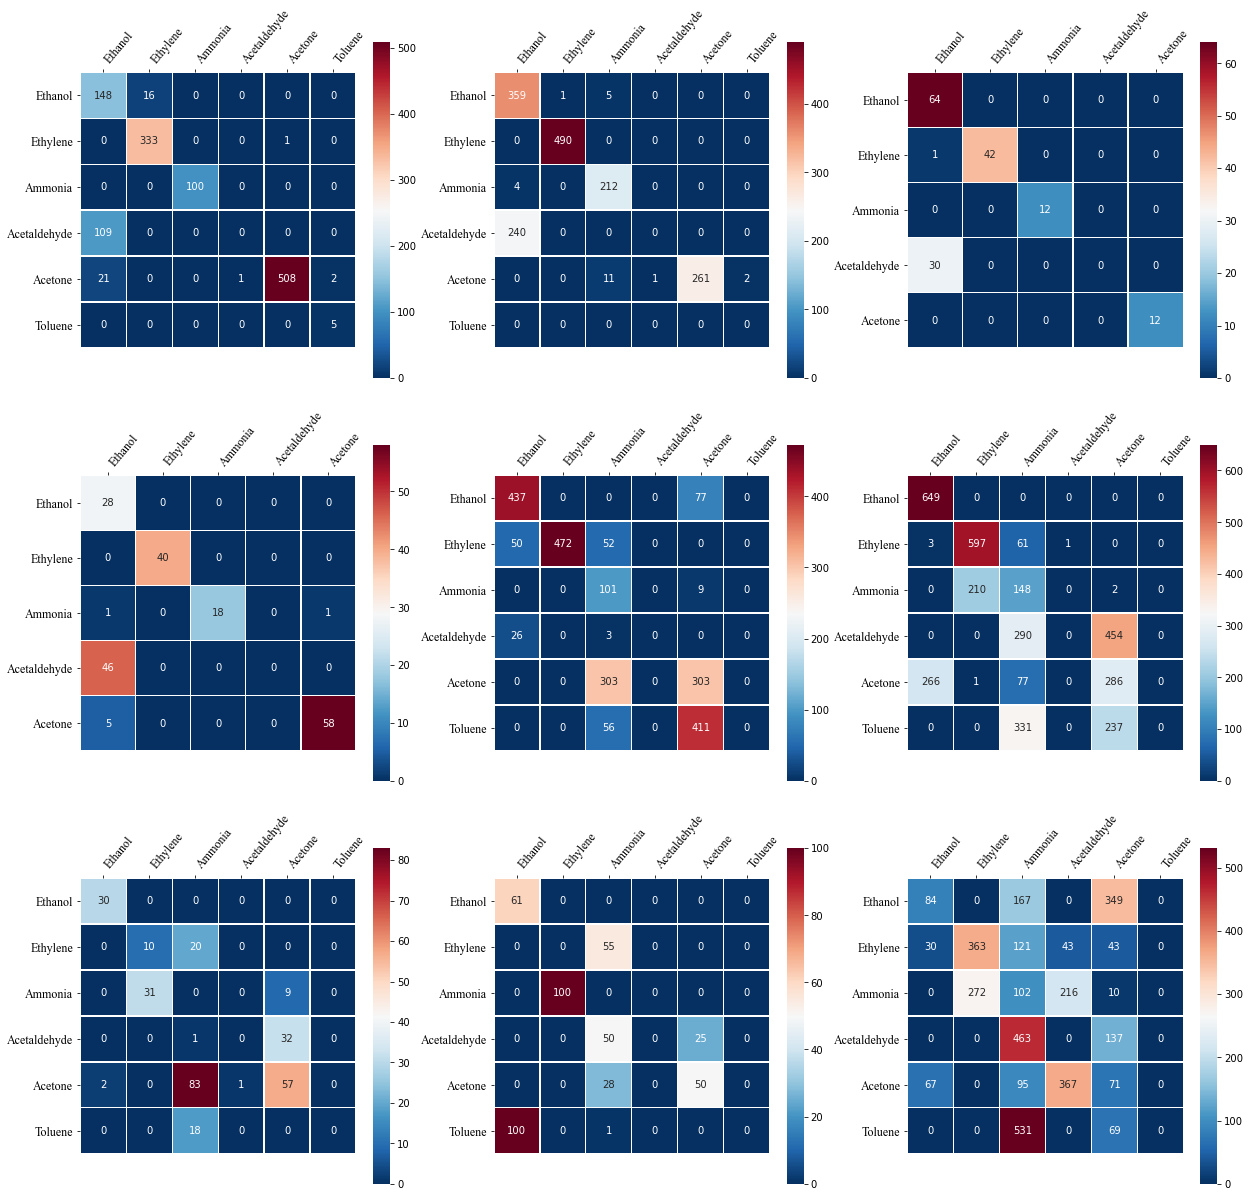

[0, 0, 0.8794212218649518, 0.8335435056746532, 0.8074534161490683, 0.7309644670050761, 0.5708695652173913, 0.4649875449764738, 0.3299319727891156, 0.23617021276595745, 0.17222222222222222]
Initialization time: 0.6266325000001416
Online analysis time: 786.8288229999998
Number of online processing steps: 13465


In [13]:
batch=batch_backup
is_forget=True
start_number=[0,90,98,83,30,70,74]  #batch1
ri=400
run(batch,ri,start_number,is_forget)

Initializing the sample set ... Finish
is_forget: True queue_capacity: [0, 500, 500, 500, 500, 500, 500] coefficient_for_starting_training: [0, 90, 98, 83, 30, 70, 74]
[[148  16   0   0   0   0]
 [  0 333   0   0   1   0]
 [  0   0 100   0   0   0]
 [109   0   0   0   0   0]
 [ 21   0   0   1 508   2]
 [  0   0   0   0   0   5]]
[[359   1   5   0   0   0]
 [  0 490   0   0   0   0]
 [  4   0 212   0   0   0]
 [240   0   0   0   0   0]
 [  0   0  11   1 261   2]
 [  0   0   0   0   0   0]]
[[64  0  0  0  0]
 [ 1 42  0  0  0]
 [ 0  0 12  0  0]
 [30  0  0  0  0]
 [ 0  0  0  0 12]]
[[28  0  0  0  0]
 [ 0 40  0  0  0]
 [ 1  0 18  0  1]
 [46  0  0  0  0]
 [ 5  0  0  0 58]]
[[488   0   0   0  26   0]
 [ 50 472  52   0   0   0]
 [  0   0 101   0   9   0]
 [ 29   0   0   0   0   0]
 [  2   0  36   0 568   0]
 [ 96   0  50   0 321   0]]
[[649   0   0   0   0   0]
 [  4 585  72   1   0   0]
 [  0   0 358   0   2   0]
 [202   0 226   0 316   0]
 [141   1  25   0 463   0]
 [ 96   0 244   0 228   0]

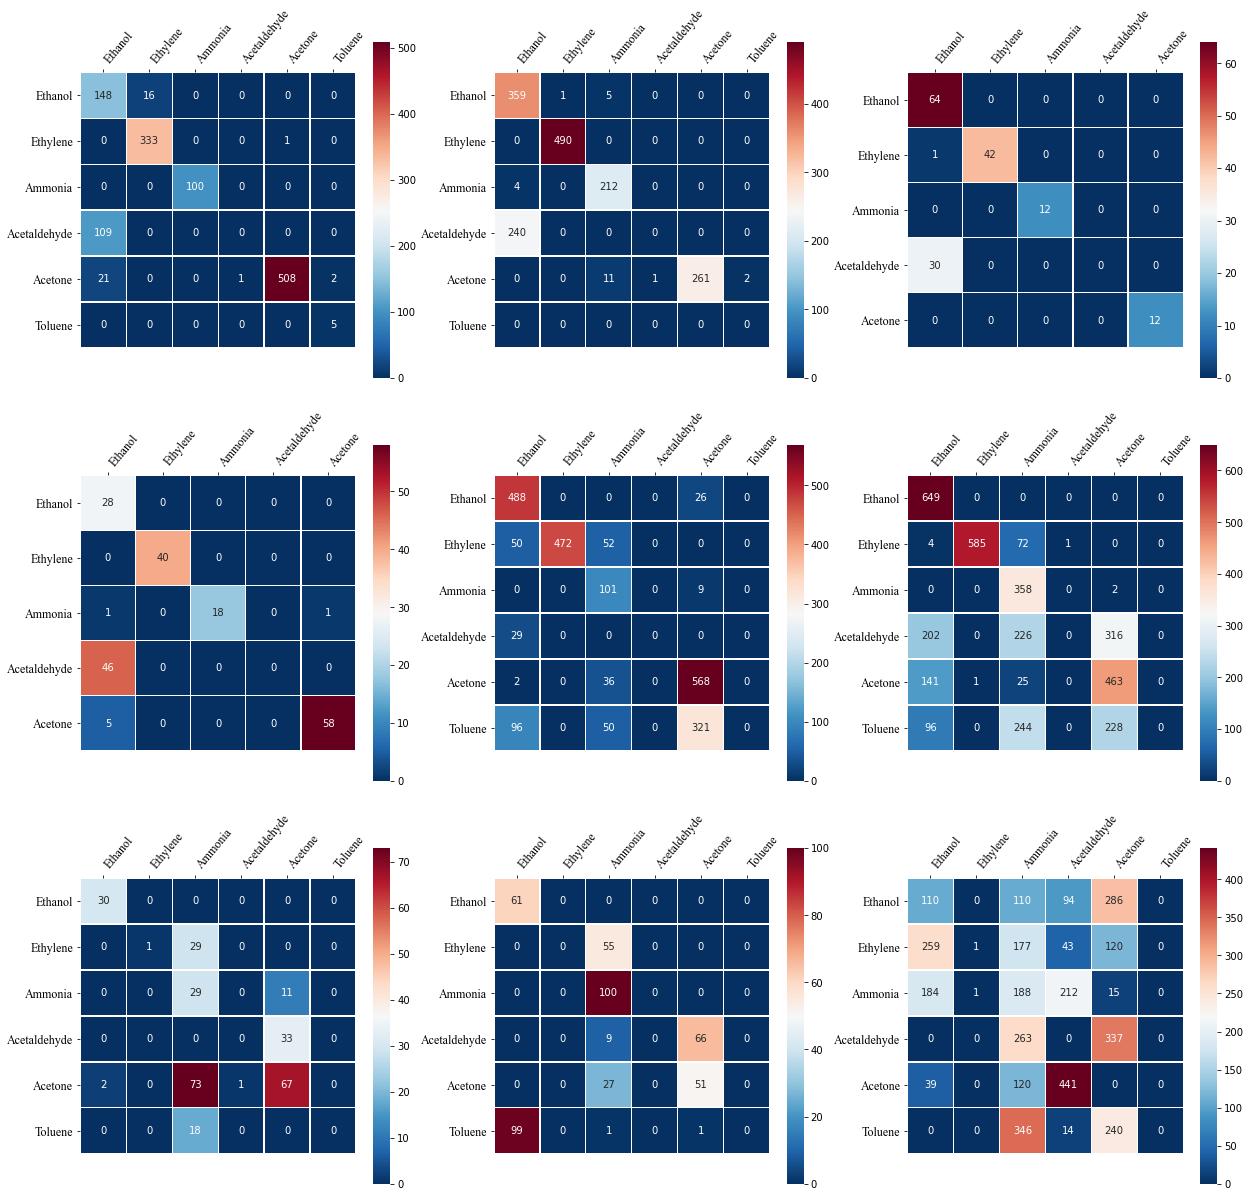

[0, 0, 0.8794212218649518, 0.8335435056746532, 0.8074534161490683, 0.7309644670050761, 0.7082608695652174, 0.5687794076944368, 0.43197278911564624, 0.451063829787234, 0.08305555555555555]
Initialization time: 0.5842952000002697
Online analysis time: 1075.6749707999998
Number of online processing steps: 13465


In [14]:
batch=batch_backup
is_forget=True
start_number=[0,90,98,83,30,70,74]  #batch1
ri=500
run(batch,ri,start_number,is_forget)

Initializing the sample set ... Finish
is_forget: True queue_capacity: [0, 600, 600, 600, 600, 600, 600] coefficient_for_starting_training: [0, 90, 98, 83, 30, 70, 74]
[[148  16   0   0   0   0]
 [  0 333   0   0   1   0]
 [  0   0 100   0   0   0]
 [109   0   0   0   0   0]
 [ 21   0   0   1 508   2]
 [  0   0   0   0   0   5]]
[[359   1   5   0   0   0]
 [  0 490   0   0   0   0]
 [  2   0 214   0   0   0]
 [240   0   0   0   0   0]
 [  0   0  11   2 260   2]
 [  0   0   0   0   0   0]]
[[34 30  0  0  0]
 [ 0 43  0  0  0]
 [ 0  0 12  0  0]
 [20 10  0  0  0]
 [ 0  0  0  0 12]]
[[28  0  0  0  0]
 [ 0 40  0  0  0]
 [ 1  0 18  0  1]
 [46  0  0  0  0]
 [ 2  3  0  0 58]]
[[487   0   0   0  27   0]
 [ 50 472  52   0   0   0]
 [  0   0 101   0   9   0]
 [ 29   0   0   0   0   0]
 [  1   0  36   0 569   0]
 [ 96   0  49   0 322   0]]
[[649   0   0   0   0   0]
 [  4 586  72   0   0   0]
 [  0   0 358   0   2   0]
 [247   0 214   0 283   0]
 [  0   1  21   0 608   0]
 [ 95   0 218   0 255   0]

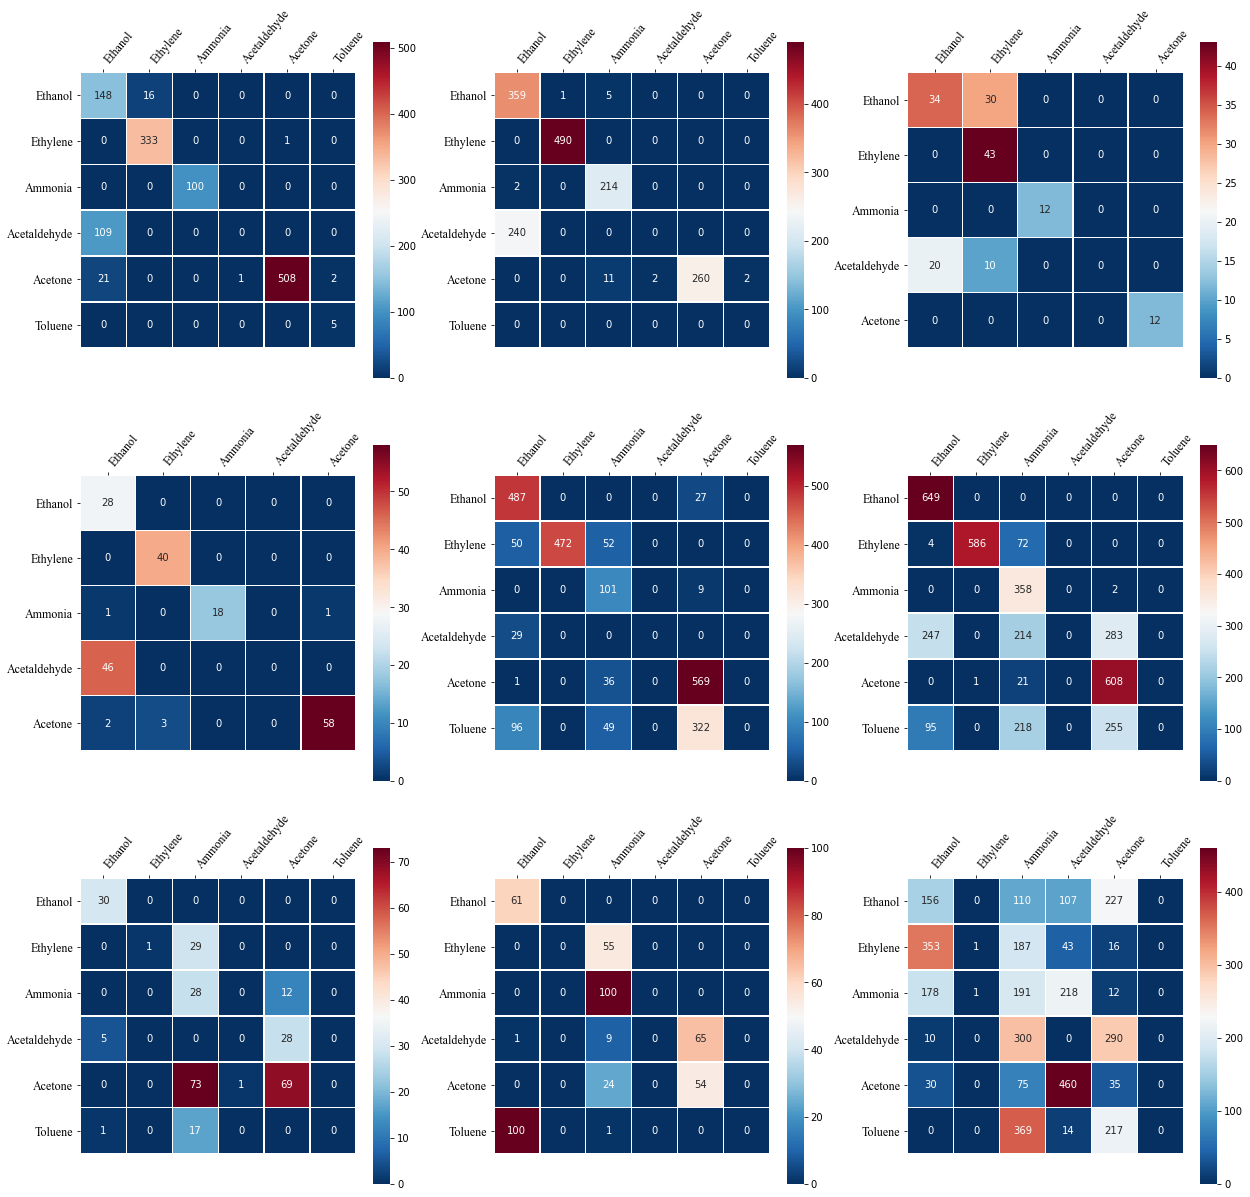

[0, 0, 0.8794212218649518, 0.8341740226986128, 0.6273291925465838, 0.7309644670050761, 0.7082608695652174, 0.6091890395792969, 0.43537414965986393, 0.4574468085106383, 0.1063888888888889]
Initialization time: 0.6671648000001369
Online analysis time: 1372.8594064
Number of online processing steps: 13465


In [15]:
batch=batch_backup
is_forget=True
start_number=[0,90,98,83,30,70,74]  #batch1
ri=600
run(batch,ri,start_number,is_forget)

Initializing the sample set ... Finish
is_forget: True queue_capacity: [0, 602, 602, 602, 602, 602, 602] coefficient_for_starting_training: [0, 254, 432, 183, 139, 602, 79]
[[364   1   0   0   0]
 [  0 490   0   0   0]
 [  0   0 212   4   0]
 [  1   0   0 239   0]
 [  5   0   6   2 262]]
[[63  0  0  1  0]
 [ 0 43  0  0  0]
 [ 0  0 12  0  0]
 [12  0  0 18  0]
 [ 0  0  0  0 12]]
[[28  0  0  0  0]
 [ 0 40  0  0  0]
 [ 0  0 18  1  1]
 [ 0  0  0 46  0]
 [ 3  0  0  2 58]]
[[437   0   0  50  27   0]
 [ 50 472  51   1   0   0]
 [  0   0 101   0   9   0]
 [  0   0   0  29   0   0]
 [  0   0  37   1 568   0]
 [  1   0  49 410   7   0]]
[[505   0   0 144   0   0]
 [ 61 517  84   0   0   0]
 [  0  31 327   0   2   0]
 [  0   0 220 215 309   0]
 [  0   0  19   0 611   0]
 [  0   0 243 174 151   0]]
[[ 0  0  0 30  0  0]
 [ 0  1 29  0  0  0]
 [ 0  0 28  0 12  0]
 [ 0  0  0 12 21  0]
 [ 1  0 74  0 68  0]
 [ 0  0 16  1  1  0]]
[[  0   0   0  61   0   0]
 [  0   0  55   0   0   0]
 [  0   0 100   0   0 

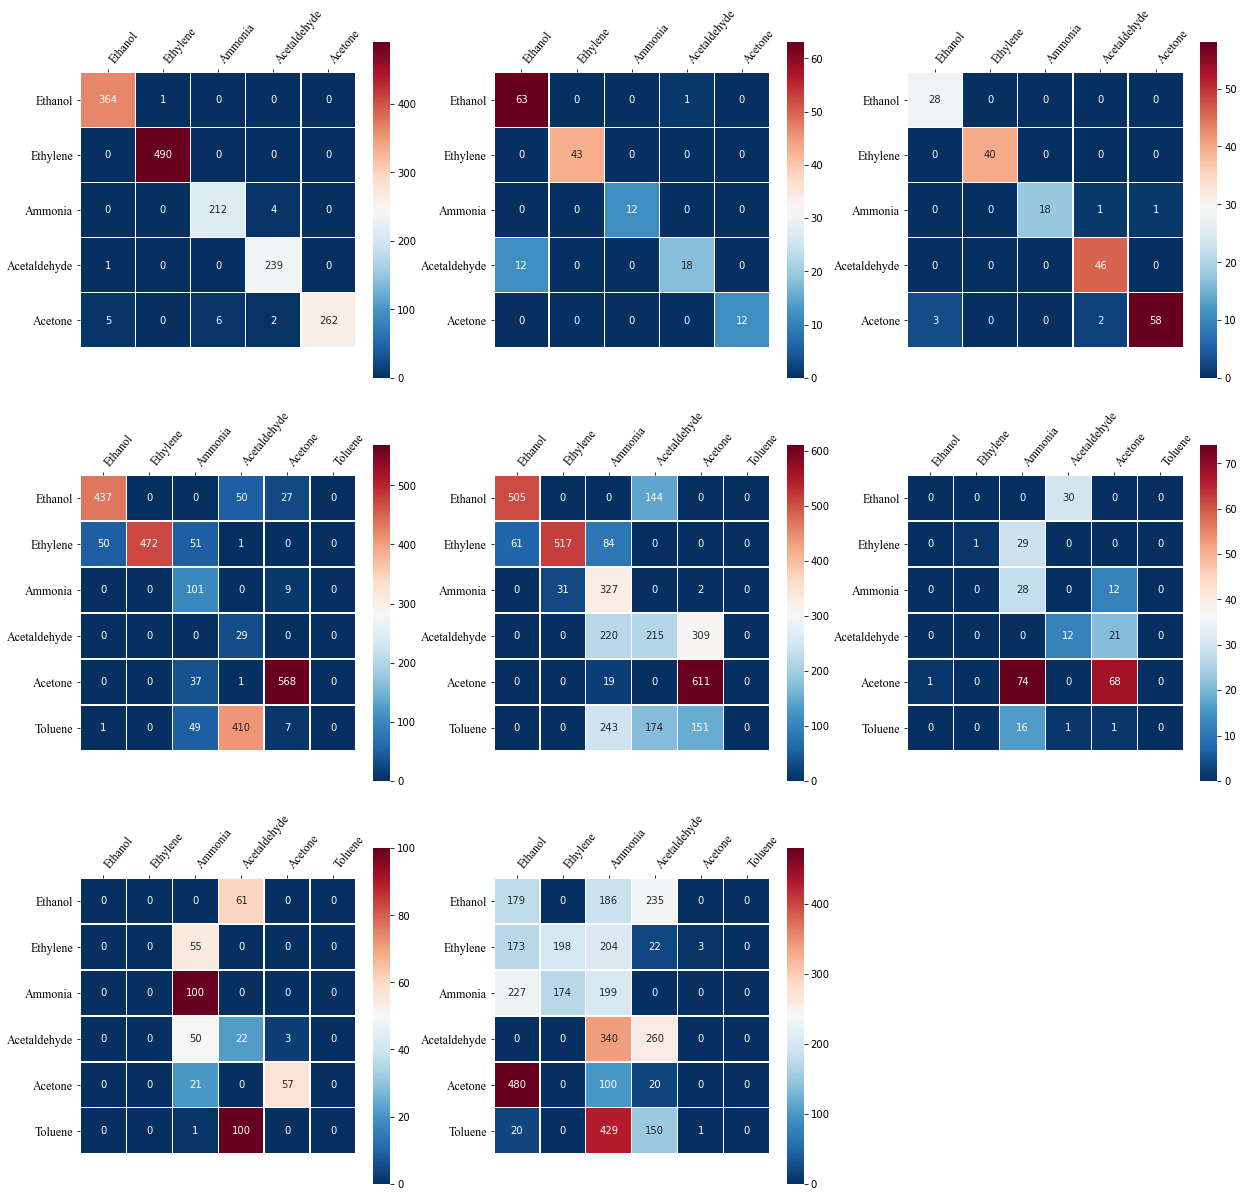

[0, 0, 0, 0.9880201765447667, 0.9192546583850931, 0.9644670050761421, 0.698695652173913, 0.6019928037641848, 0.3707482993197279, 0.38085106382978723, 0.23222222222222222]
Initialization time: 2.650615100000323
Online analysis time: 1671.7117806999995
Number of online processing steps: 12221


In [16]:
batch=batch_backup
is_forget=True
start_number=[0,254,432,183,139,602,79] #batch1,2
ri=602
run(batch,ri,start_number,is_forget)

Initializing the sample set ... Finish
is_forget: True queue_capacity: [0, 700, 700, 700, 700, 700, 700] coefficient_for_starting_training: [0, 254, 432, 183, 139, 602, 79]
[[364   1   0   0   0]
 [  0 490   0   0   0]
 [  0   0 212   4   0]
 [  1   0   0 239   0]
 [  5   0   6   2 262]]
[[63  0  0  1  0]
 [ 0 43  0  0  0]
 [ 0  2 10  0  0]
 [12  0  0 18  0]
 [ 0  0  0  0 12]]
[[28  0  0  0  0]
 [ 0 40  0  0  0]
 [ 0  0 18  1  1]
 [ 0  0  0 46  0]
 [ 3  0  0  2 58]]
[[487   0   0   0  27   0]
 [ 50 472  51   1   0   0]
 [  0   0 101   0   9   0]
 [  0   0   0  29   0   0]
 [  0   0  37   1 568   0]
 [  1   0  49 408   9   0]]
[[649   0   0   0   0   0]
 [ 61 517  84   0   0   0]
 [  0  30 328   0   2   0]
 [  0   0 221 269 254   0]
 [  0   0  21   0 609   0]
 [  0   0 232 191 145   0]]
[[30  0  0  0  0  0]
 [ 0  1 29  0  0  0]
 [ 0  0 27  1 12  0]
 [ 0  0  0 10 23  0]
 [ 1  0 74  0 68  0]
 [ 0  0 17  1  0  0]]
[[ 61   0   0   0   0   0]
 [  0   0  55   0   0   0]
 [  0   0 100   0   0 

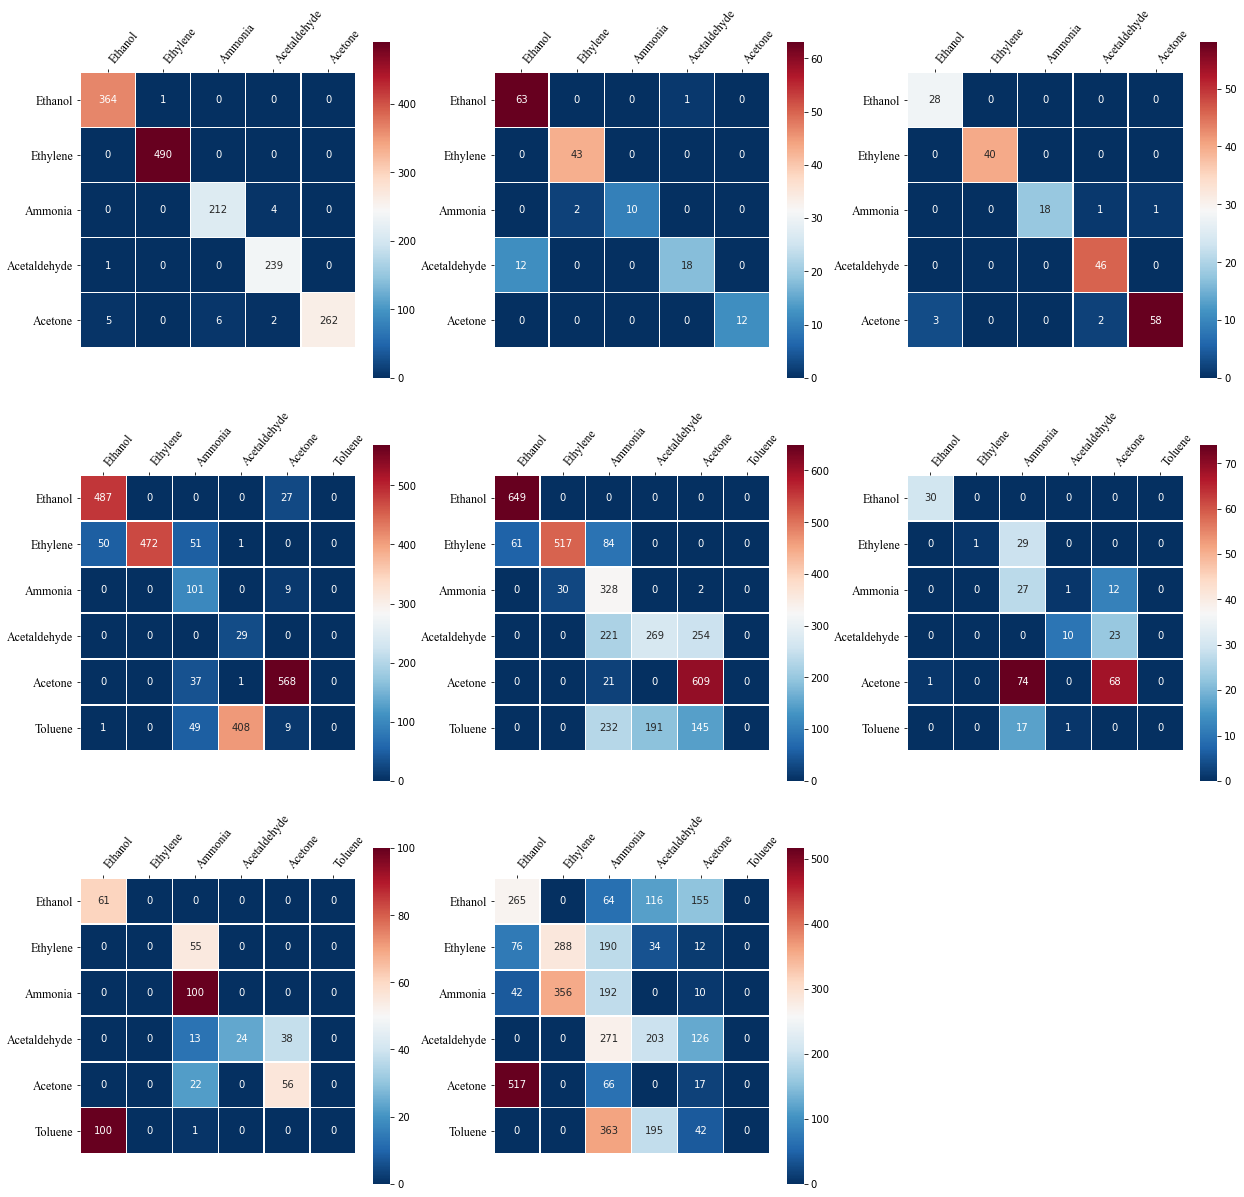

[0, 0, 0, 0.9880201765447667, 0.906832298136646, 0.9644670050761421, 0.7204347826086956, 0.6565181289786881, 0.46258503401360546, 0.5127659574468085, 0.26805555555555555]
Initialization time: 2.4788235999994868
Online analysis time: 2033.9243158
Number of online processing steps: 12221


In [17]:
batch=batch_backup
is_forget=True
start_number=[0,254,432,183,139,602,79] #batch1,2
ri=700
run(batch,ri,start_number,is_forget)

Initializing the sample set ... Finish
is_forget: True queue_capacity: [0, 800, 800, 800, 800, 800, 800] coefficient_for_starting_training: [0, 254, 432, 183, 139, 602, 79]
[[364   1   0   0   0]
 [  0 490   0   0   0]
 [  0   0 212   4   0]
 [  1   0   0 239   0]
 [  5   0   6   2 262]]
[[63  0  0  1  0]
 [ 0 43  0  0  0]
 [ 0  2 10  0  0]
 [12  0  0 18  0]
 [ 0  0  0  0 12]]
[[28  0  0  0  0]
 [ 0 40  0  0  0]
 [ 0  0 18  1  1]
 [ 0  0  0 46  0]
 [ 3  0  0  2 58]]
[[487   0   0   0  27   0]
 [ 50 472  51   1   0   0]
 [  0   0 101   0   9   0]
 [  0   0   0  29   0   0]
 [  1   0  37   0 568   0]
 [  1   0  49 409   8   0]]
[[649   0   0   0   0   0]
 [ 61 516  85   0   0   0]
 [  0  30 328   0   2   0]
 [  0   0 221 269 254   0]
 [  0   0  23   0 607   0]
 [  0   0 235 192 141   0]]
[[30  0  0  0  0  0]
 [ 0  1 29  0  0  0]
 [ 0  0 29  0 11  0]
 [ 0  0  0 10 23  0]
 [ 1  0 74  0 68  0]
 [ 0  0 18  0  0  0]]
[[ 61   0   0   0   0   0]
 [  0   0  55   0   0   0]
 [  0   0 100   0   0 

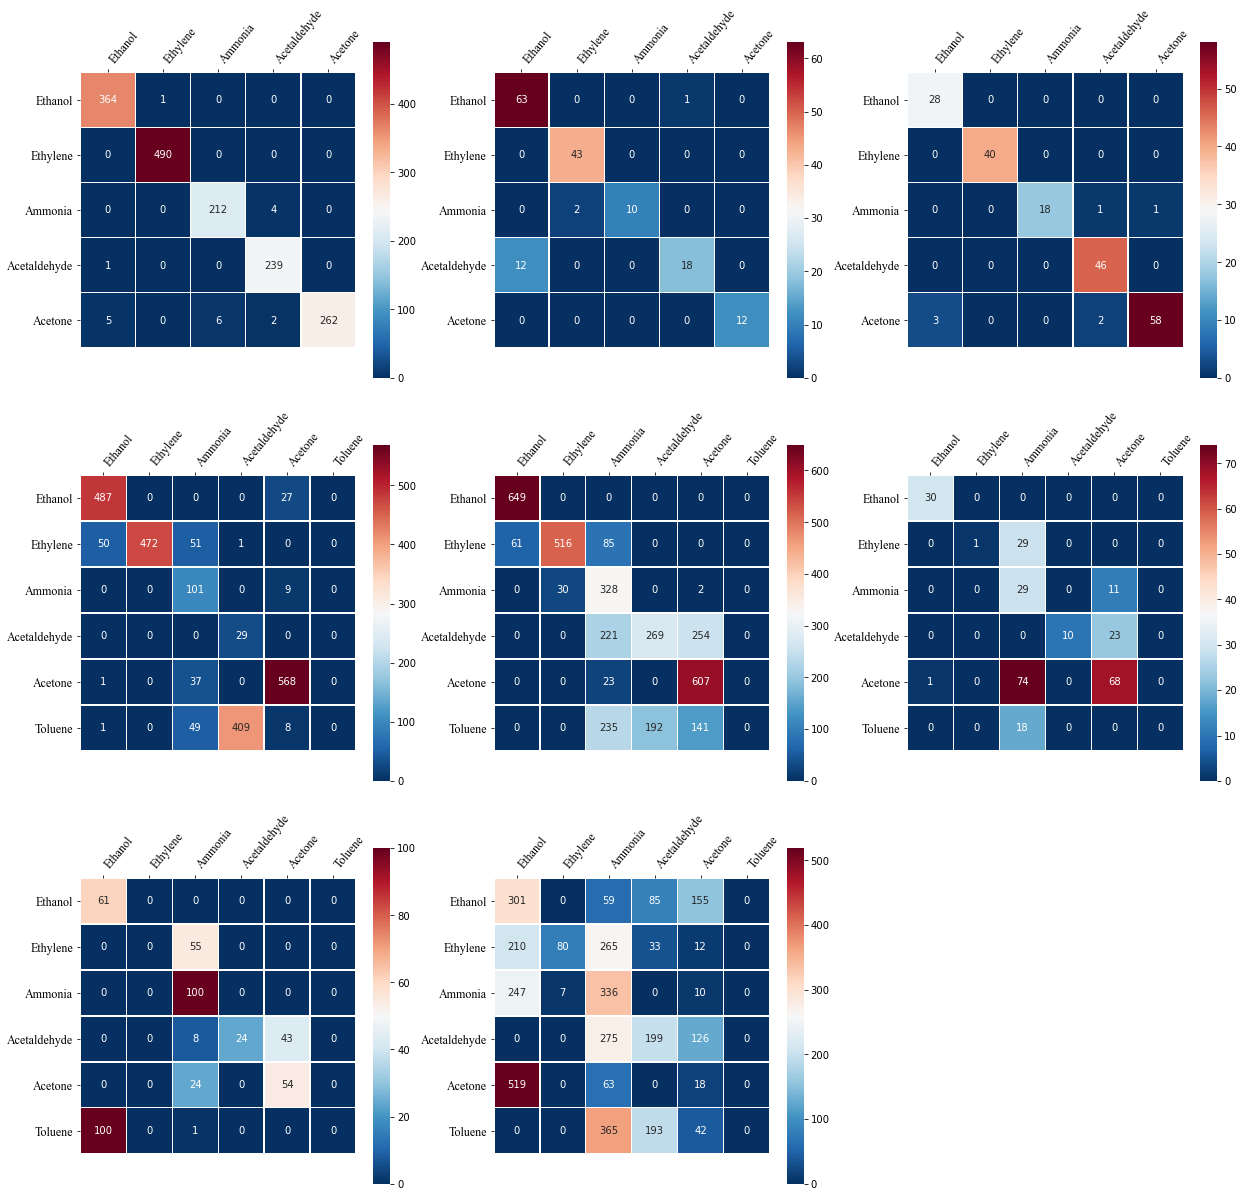

[0, 0, 0, 0.9880201765447667, 0.906832298136646, 0.9644670050761421, 0.7204347826086956, 0.6556877940769443, 0.46938775510204084, 0.5085106382978724, 0.2594444444444444]
Initialization time: 2.8484361999999237
Online analysis time: 2711.0114897000003
Number of online processing steps: 12221


In [18]:
batch=batch_backup
is_forget=True
start_number=[0,254,432,183,139,602,79] #batch1,2
ri=800
run(batch,ri,start_number,is_forget)

Initializing the sample set ... Finish
is_forget: True queue_capacity: [0, 900, 900, 900, 900, 900, 900] coefficient_for_starting_training: [0, 254, 432, 183, 139, 602, 79]
[[364   1   0   0   0]
 [  0 490   0   0   0]
 [  0   0 212   4   0]
 [  1   0   0 239   0]
 [  5   0   6   2 262]]
[[63  0  0  1  0]
 [ 0 43  0  0  0]
 [ 0  2 10  0  0]
 [12  0  0 18  0]
 [ 0  0  0  0 12]]
[[28  0  0  0  0]
 [ 0 40  0  0  0]
 [ 0  0 18  1  1]
 [ 0  0  0 46  0]
 [ 3  0  0  4 56]]
[[487   0   0   0  27   0]
 [ 50 472  51   1   0   0]
 [  0   0 101   0   9   0]
 [  0   0   0  29   0   0]
 [  2   0  36   0 568   0]
 [  1   0  49 409   8   0]]
[[649   0   0   0   0   0]
 [ 61 540  61   0   0   0]
 [  0   1 357   0   2   0]
 [  0   0 221   4 519   0]
 [  0   1  27   0 602   0]
 [  0   0 265 173 130   0]]
[[30  0  0  0  0  0]
 [ 0  1 29  0  0  0]
 [ 0  0 28  3  9  0]
 [ 0  0  0  0 33  0]
 [ 1  0 75  0 67  0]
 [ 0  0 17  1  0  0]]
[[ 61   0   0   0   0   0]
 [  0   0  55   0   0   0]
 [  0   0 100   0   0 

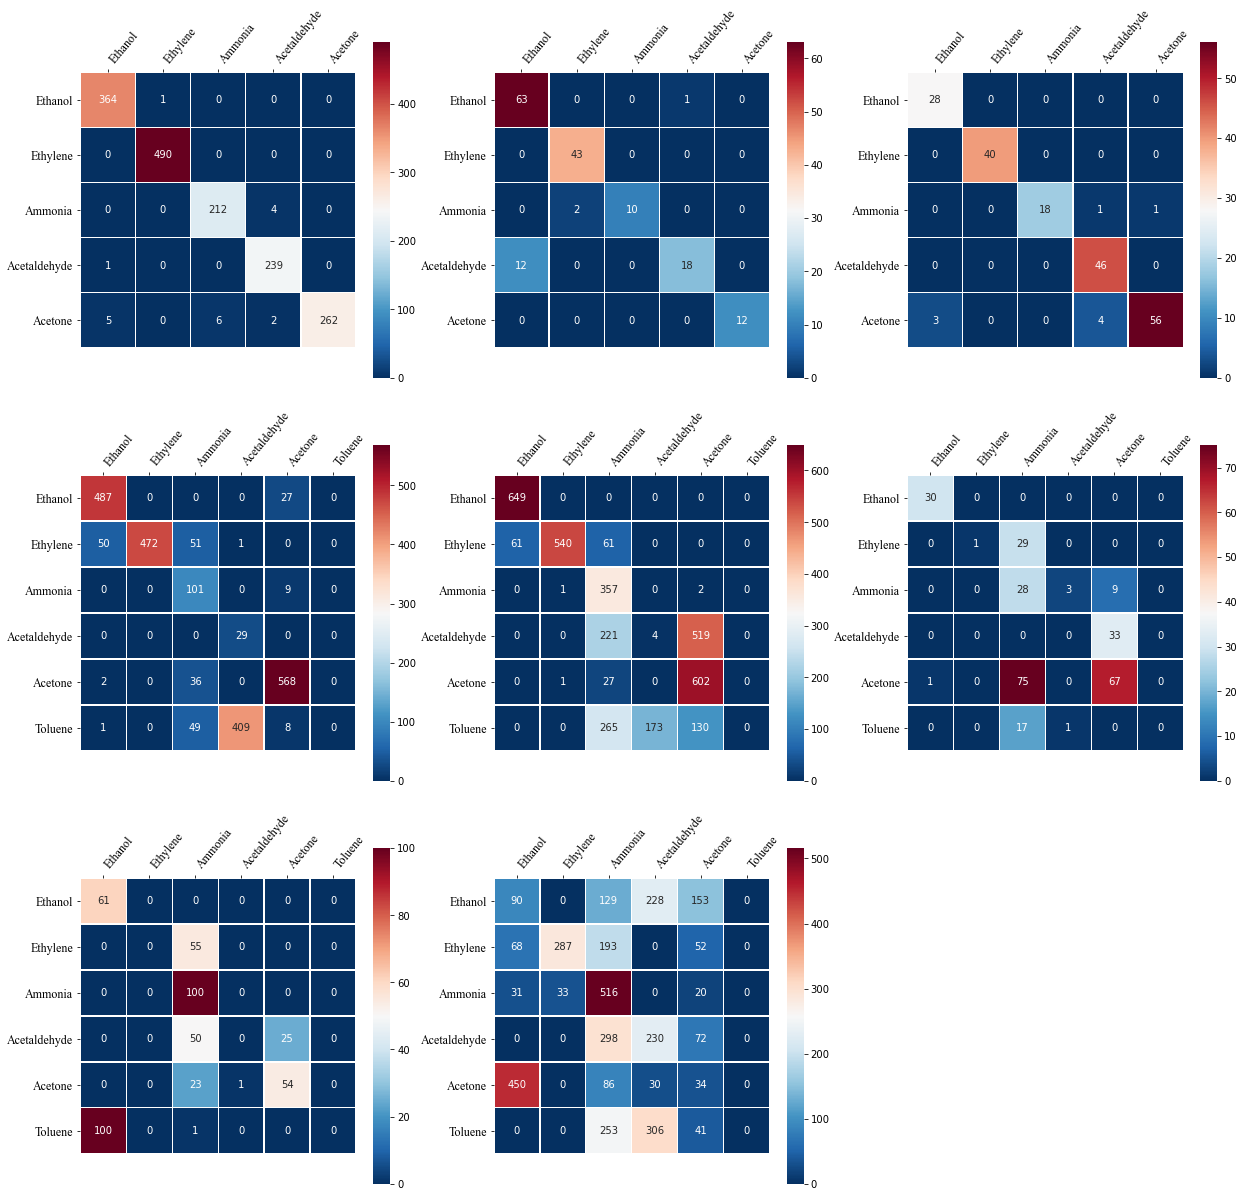

[0, 0, 0, 0.9880201765447667, 0.906832298136646, 0.9543147208121827, 0.7204347826086956, 0.5956269028508165, 0.42857142857142855, 0.4574468085106383, 0.3213888888888889]
Initialization time: 2.7885502999997698
Online analysis time: 3211.051813
Number of online processing steps: 12221


In [19]:
batch=batch_backup
is_forget=True
start_number=[0,254,432,183,139,602,79] #batch1,2
ri=900
run(batch,ri,start_number,is_forget)

Initializing the sample set ... Finish
is_forget: True queue_capacity: [0, 1000, 1000, 1000, 1000, 1000, 1000] coefficient_for_starting_training: [0, 254, 432, 183, 139, 602, 79]
[[364   1   0   0   0]
 [  0 490   0   0   0]
 [  0   0 212   4   0]
 [  1   0   0 239   0]
 [  5   0   6   2 262]]
[[63  0  0  1  0]
 [ 0 43  0  0  0]
 [ 0  2 10  0  0]
 [12  0  0 18  0]
 [ 0  0  0  0 12]]
[[28  0  0  0  0]
 [ 0 40  0  0  0]
 [ 0  0 18  1  1]
 [ 0  0  0 46  0]
 [ 3  0  0  4 56]]
[[487   0   0   0  27   0]
 [ 50 472  51   1   0   0]
 [  0   0 101   0   9   0]
 [  0   0   0  29   0   0]
 [  2   0  36   0 568   0]
 [  1   0  49 409   8   0]]
[[649   0   0   0   0   0]
 [ 61 540  61   0   0   0]
 [  0   1 357   0   2   0]
 [  0   0 220   1 523   0]
 [  0   1  17   0 612   0]
 [  0   0 247 172 149   0]]
[[30  0  0  0  0  0]
 [ 0  1 29  0  0  0]
 [ 0  0 28  3  9  0]
 [ 0  0  0  0 33  0]
 [ 1  0 73  0 69  0]
 [ 0  0 17  1  0  0]]
[[ 61   0   0   0   0   0]
 [  0   0  55   0   0   0]
 [  0   0 100   

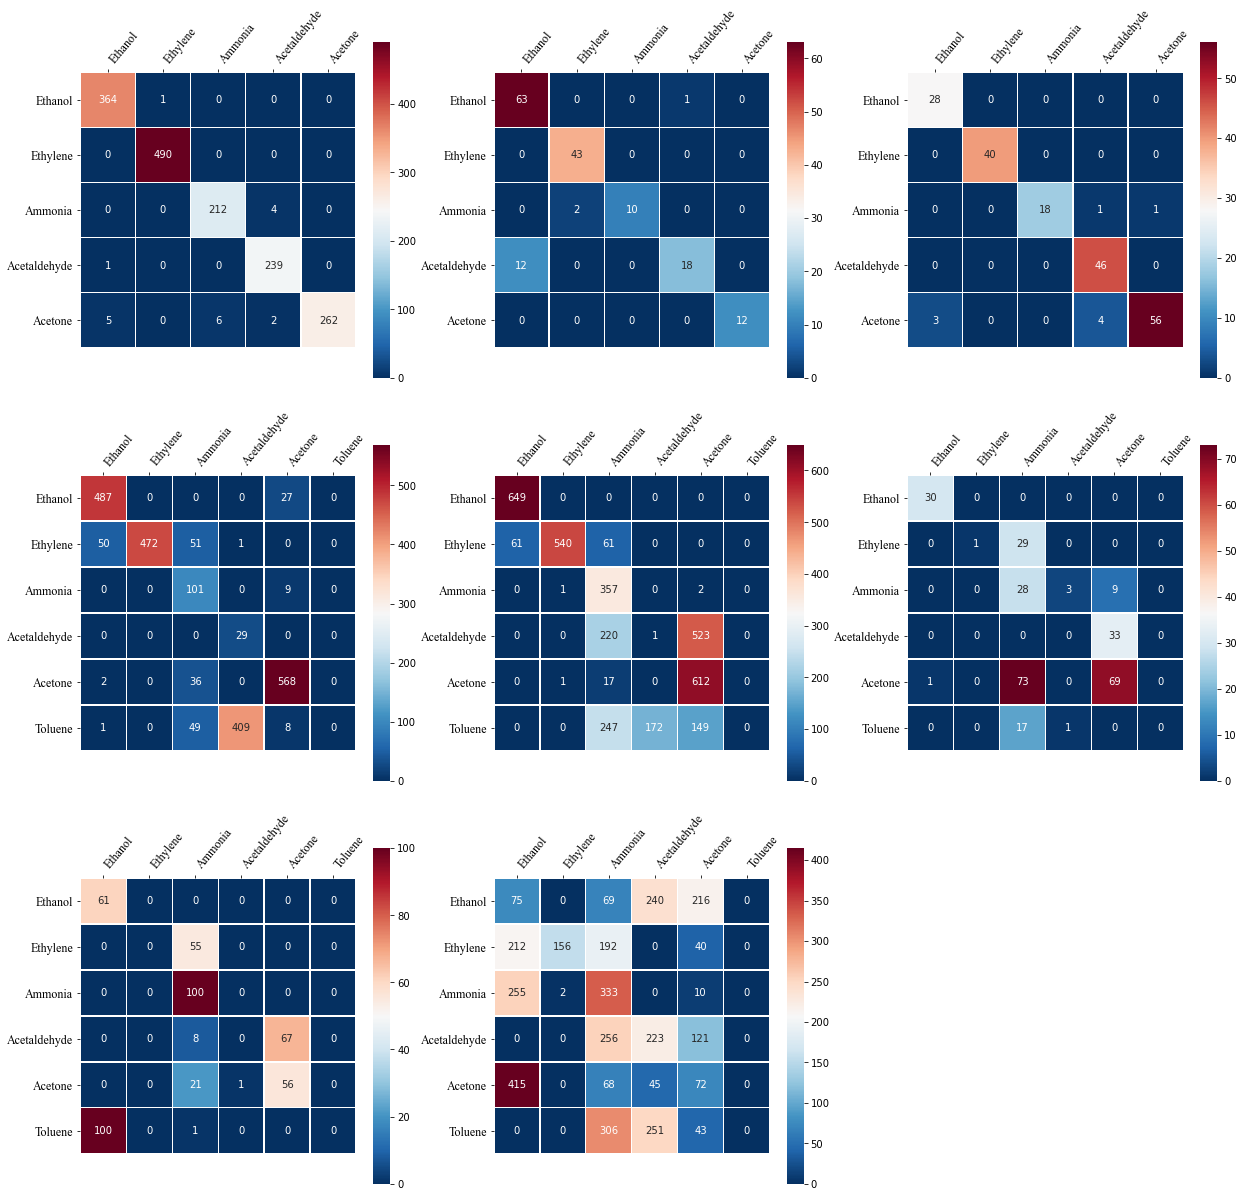

[0, 0, 0, 0.9880201765447667, 0.906832298136646, 0.9543147208121827, 0.7204347826086956, 0.5975643509548851, 0.43537414965986393, 0.46170212765957447, 0.2386111111111111]
Initialization time: 2.677337199998874
Online analysis time: 3744.4338204000014
Number of online processing steps: 12221


In [20]:
batch=batch_backup
is_forget=True
start_number=[0,254,432,183,139,602,79] #batch1,2
ri=1000
run(batch,ri,start_number,is_forget)

Initializing the sample set ... Finish
is_forget: True queue_capacity: [0, 1100, 1100, 1100, 1100, 1100, 1100] coefficient_for_starting_training: [0, 254, 432, 183, 139, 602, 79]
[[364   1   0   0   0]
 [  0 490   0   0   0]
 [  0   0 212   4   0]
 [  1   0   0 239   0]
 [  5   0   6   2 262]]
[[63  0  0  1  0]
 [ 0 43  0  0  0]
 [ 0  2 10  0  0]
 [12  0  0 18  0]
 [ 0  0  0  0 12]]
[[28  0  0  0  0]
 [ 0 40  0  0  0]
 [ 0  0 18  1  1]
 [ 0  0  0 46  0]
 [ 3  0  0  4 56]]
[[487   0   0   0  27   0]
 [ 95 477   1   1   0   0]
 [  0   0 101   0   9   0]
 [  0   0   0  29   0   0]
 [ 39   0   0   0 567   0]
 [ 51   0   0 410   6   0]]
[[649   0   0   0   0   0]
 [ 65 597   0   0   0   0]
 [ 62   0 296   0   2   0]
 [214   0   0 277 253   0]
 [ 14   1   0   0 615   0]
 [219   0   0 194 155   0]]
[[30  0  0  0  0  0]
 [29  1  0  0  0  0]
 [ 0  0 31  0  9  0]
 [ 0  0  0 10 23  0]
 [73  0  1  0 69  0]
 [17  0  0  1  0  0]]
[[ 61   0   0   0   0   0]
 [ 55   0   0   0   0   0]
 [  0   0 100   

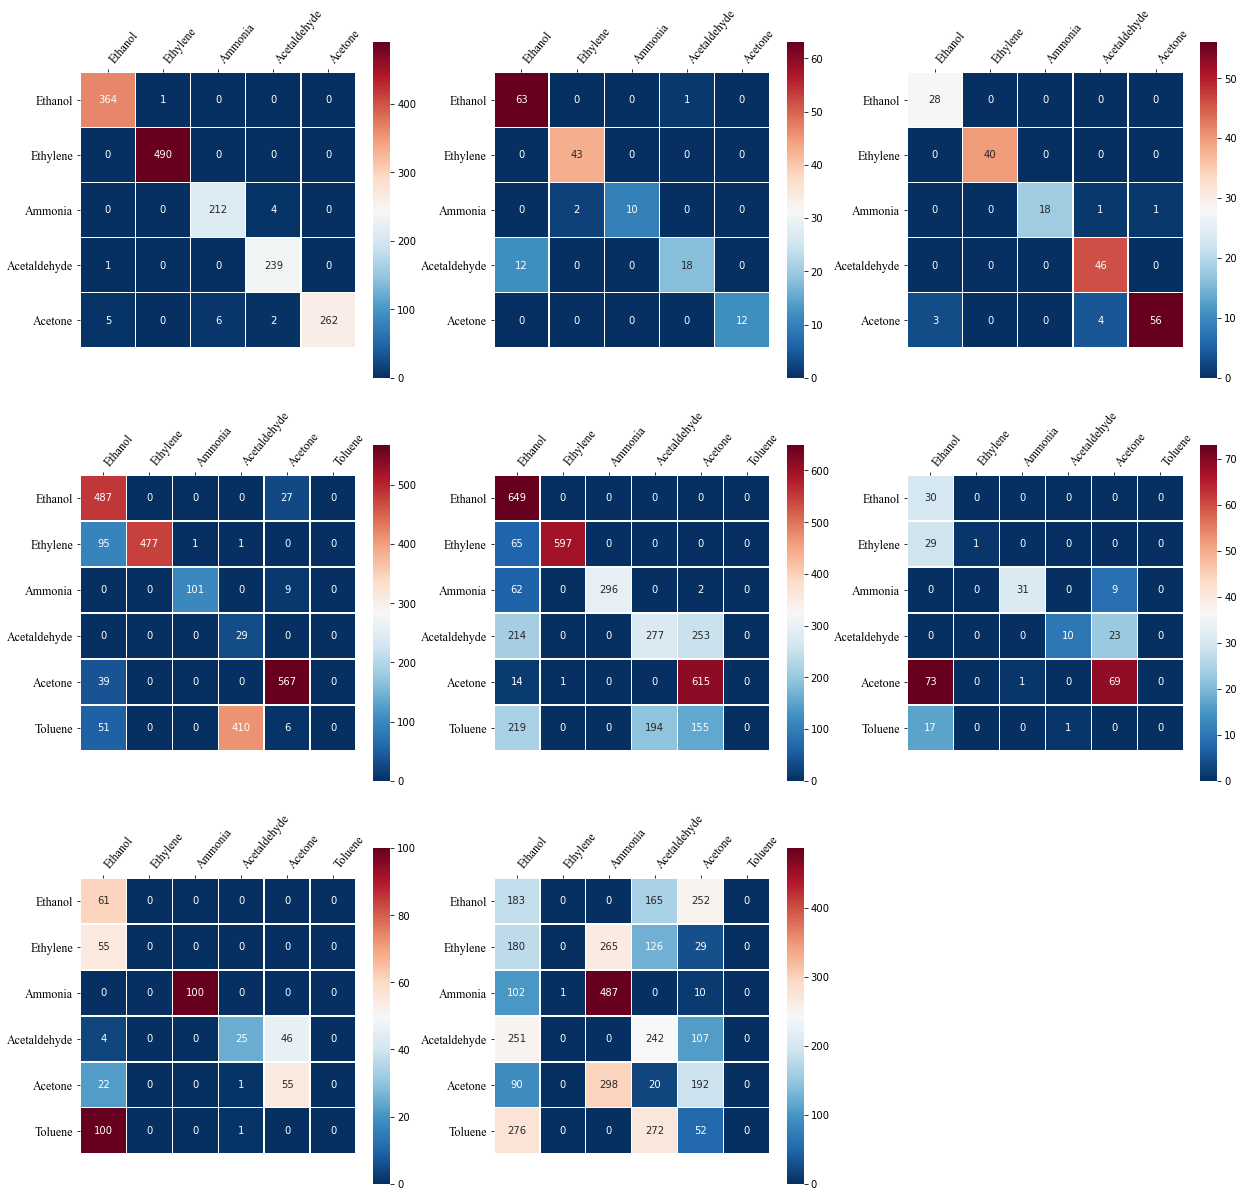

[0, 0, 0, 0.9880201765447667, 0.906832298136646, 0.9543147208121827, 0.7221739130434782, 0.6736783836147247, 0.47959183673469385, 0.5127659574468085, 0.30666666666666664]
Initialization time: 2.5768325999997614
Online analysis time: 4315.9127993
Number of online processing steps: 12221


In [21]:
batch=batch_backup
is_forget=True
start_number=[0,254,432,183,139,602,79] #batch1,2
ri=1100
run(batch,ri,start_number,is_forget)